In [188]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
from src.configs import ModelArgs
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
import numpy as np
import pickle


treescope.basic_interactive_setup()

In [189]:
# Write new configs on wandb.
import wandb

api = wandb.Api()

for run in api.runs("csml/encoderops_chignolin"):
    updated: bool = False
    if run.state == "finished":
        model_args = asdict(eval(run.config['model_args']))
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

2025-04-16 11:28:36.829 | INFO     | __main__:<module>:18 - Run liq5y008 was already up to date
2025-04-16 11:28:37.237 | INFO     | __main__:<module>:18 - Run fmxldw5g was already up to date
2025-04-16 11:28:37.621 | INFO     | __main__:<module>:18 - Run 6gm38ox1 was already up to date
2025-04-16 11:28:38.008 | INFO     | __main__:<module>:18 - Run 5kigk9xx was already up to date
2025-04-16 11:28:38.425 | INFO     | __main__:<module>:18 - Run b8qyu8rs was already up to date
2025-04-16 11:28:38.867 | INFO     | __main__:<module>:18 - Run nu8v1mpx was already up to date
2025-04-16 11:28:39.242 | INFO     | __main__:<module>:18 - Run 73dtj1jp was already up to date
2025-04-16 11:28:39.669 | INFO     | __main__:<module>:18 - Run p52qnu9d was already up to date
2025-04-16 11:28:40.048 | INFO     | __main__:<module>:18 - Run b1du1e7n was already up to date
2025-04-16 11:28:40.677 | INFO     | __main__:<module>:18 - Run 49x4nrkj was already up to date
2025-04-16 11:28:41.167 | INFO     | __m

In [ ]:
reg = 1e-4
if Path("results.pkl").exists():
    results = pickle.load(open("results.pkl", "rb"))
else:
    results = {}
    for run in api.runs("csml/encoderops_chignolin"):
        if run.state == "finished":
            logger.info(f"Run {run.id}")
            data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run.id}")
            epoch = 249
            model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
            dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
            embeddings = {"t": [], "lag": []}
            model = model.eval()

            dataloader = DataLoader(
                dataset, batch_size=128, shuffle=False
            )
            with torch.no_grad():
                for batch in dataloader:
                    for k, v in batch.items():
                        batch[k] = v.to(model.device)
                    # data
                    x_t = model._setup_graph_data(batch)
                    x_lag = model._setup_graph_data(batch, key="item_lag")
                    # forward
                    f_t = model.forward_nn(x_t)
                    f_lag = model.forward_nn(x_lag)
                    embeddings["t"].append((f_t.detach().cpu()))
                    embeddings["lag"].append((f_lag.detach().cpu()))
            phi_t = torch.cat(embeddings["t"])
            phi_lag = torch.cat(embeddings["lag"])
            cov_X = lol.nn.stats.covariance(phi_t)
            cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
            cov_Y = lol.nn.stats.covariance(phi_lag)
            cov_XY = lol.nn.stats.covariance(phi_t, phi_lag)
            G = torch.linalg.solve(cov_X, cov_XY)
            l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
            r_fun = phi_t.to(Q.dtype) @ Q 
            results[run.id] = {
                "embedding_t": phi_t,
                "embedding_lag": phi_lag,
                "eigenvalues": l,
                "eigenvectors": Q,
                "r_fun": r_fun
            }
            pickle.dump(results, open("results.pkl", "wb"))

In [191]:
def implied_timescale(ev, lagtime_ns: float = 5.0):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    return np.sort((1/-np.log(np.abs(ev)))*lagtime_ns)[::-1]

In [215]:
model.model_args

ModelArgs(latent_dim=64, linear_lora=16, encoder_lr=0.01, linear_lr=0.01, epochs=250, max_grad_norm=None, normalize_lin=False, regularization=0.01, min_encoder_lr=0.0001, simnorm_dim=4, n_bases=16, n_layers=3, n_filters=32, n_hidden_channels=64)

fmxldw5g ModelArgs(latent_dim=64, linear_lora=16, encoder_lr=0.01, linear_lr=0.01, epochs=250, max_grad_norm=0.2, normalize_lin=True, regularization=0.0001, min_encoder_lr=0.0001, simnorm_dim=4, n_bases=16, n_layers=3, n_filters=32, n_hidden_channels=64)
p52qnu9d ModelArgs(latent_dim=64, linear_lora=16, encoder_lr=0.01, linear_lr=0.01, epochs=250, max_grad_norm=None, normalize_lin=True, regularization=0.0001, min_encoder_lr=0.0001, simnorm_dim=4, n_bases=16, n_layers=3, n_filters=32, n_hidden_channels=64)


(2.0, 100.0)

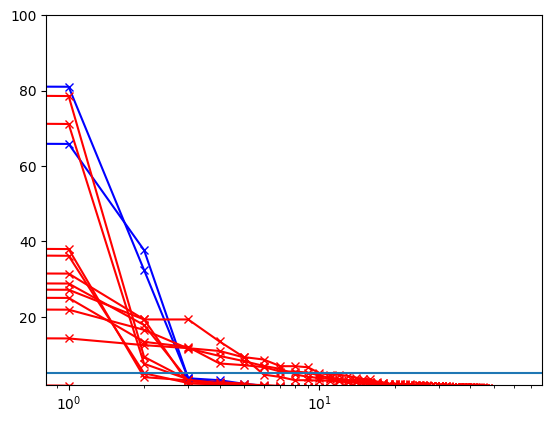

In [235]:
for run_id, values in results.items():
    data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run_id}")
    epoch = 249
    model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    color = 'r'
    if model.model_args.regularization == 0.0001:
        if model.model_args.min_encoder_lr is not None:
            if model.model_args.normalize_lin:
            #if model.model_args.max_grad_norm is None:
                color ='b'
                print(run_id, model.model_args)
    
    #color = 'b' if model.model_args.normalize_lin else 'r'
    # color = 'b' if model.model_args.max_grad_norm is None else 'r'
    # color = 'b' if model.model_args.regularization == 0.0001 else 'r'

    ts = implied_timescale(values['eigenvalues'])
    plt.plot(ts, 'x-', label=run_id, color= color)
#plt.yscale('log')
plt.xscale('log')
plt.axhline(5)
plt.ylim(2, 100)

In [237]:
results['p52qnu9d']['eigenvalues']

tensor([ 9.8484e-01+0.0000e+00j,  9.4013e-01+0.0000e+00j,
         8.5693e-01+0.0000e+00j,  2.6214e-01+0.0000e+00j,
         1.2967e-01+0.0000e+00j,  3.2399e-02+0.0000e+00j,
        -6.4544e-03+0.0000e+00j,  3.5873e-03+5.3124e-03j,
         3.5873e-03-5.3124e-03j, -2.2747e-03+5.2251e-03j,
        -2.2747e-03-5.2251e-03j,  3.5793e-03+0.0000e+00j,
         2.5779e-03+8.9778e-04j,  2.5779e-03-8.9778e-04j,
        -3.1976e-04+2.0564e-03j, -3.1976e-04-2.0564e-03j,
        -1.9817e-03+0.0000e+00j, -1.0364e-03+1.1265e-03j,
        -1.0364e-03-1.1265e-03j,  1.3204e-03+4.4131e-04j,
         1.3204e-03-4.4131e-04j, -1.0222e-03+0.0000e+00j,
         1.0048e-03+0.0000e+00j, -2.6973e-04+6.4890e-04j,
        -2.6973e-04-6.4890e-04j,  6.4577e-04+2.6179e-04j,
         6.4577e-04-2.6179e-04j, -5.1204e-04+0.0000e+00j,
         2.2569e-04+4.1714e-04j,  2.2569e-04-4.1714e-04j,
         3.7005e-04+1.1650e-04j,  3.7005e-04-1.1650e-04j,
         2.5493e-04+2.1494e-04j,  2.5493e-04-2.1494e-04j,
         3.2415e-04+0.0000e+00j, -1.8775e-04+2.2895e-04j,
        -1.8775e-04-2.2895e-04j, -4.5248e-05+2.8458e-04j,
        -4.5248e-05-2.8458e-04j,  1.7192e-04+1.0173e-04j,
         1.7192e-04-1.0173e-04j, -2.8459e-05+1.8134e-04j,
        -2.8459e-05-1.8134e-04j, -1.8875e-04+9.7628e-05j,
        -1.8875e-04-9.7628e-05j, -2.1290e-04+0.0000e+00j,
        -1.1740e-04+9.9658e-05j, -1.1740e-04-9.9658e-05j,
        -1.4659e-04+3.2657e-05j, -1.4659e-04-3.2657e-05j,
         1.4170e-04+0.0000e+00j,  8.9544e-05+7.6341e-05j,
         8.9544e-05-7.6341e-05j,  9.3769e-05+1.9199e-05j,
         9.3769e-05-1.9199e-05j, -1.2631e-05+8.1902e-05j,
        -1.2631e-05-8.1902e-05j, -3.9374e-05+6.8125e-05j,
        -3.9374e-05-6.8125e-05j, -8.2747e-05+0.0000e+00j,
        -6.7153e-05+0.0000e+00j,  1.7400e-05+0.0000e+00j,
        -5.9861e-06+1.0662e-05j, -5.9861e-06-1.0662e-05j])

(-1.0994713695023444,
 1.0999748271191592,
 -1.0998615404412626,
 1.0998615404412626)

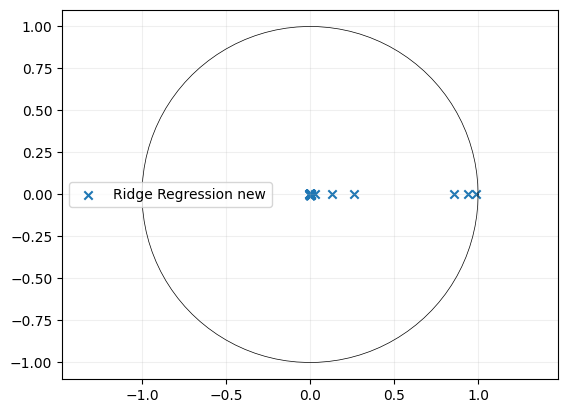

In [238]:
N = phi_t.shape[0]
plt.scatter(results['p52qnu9d']['eigenvalues'].real, results['p52qnu9d']['eigenvalues'].imag, marker='x', label="Ridge Regression new")
#plt.scatter(e1.real, e1.imag, label="end2end")
plt.grid(alpha=0.2)
plt.legend()
# Draw unit circle
t = np.linspace(0, 2 * np.pi, 100)
r = 1
x = r * np.cos(t)
y = r * np.sin(t)
plt.plot(x, y, color='k', lw=0.5)
plt.axis('equal')

In [239]:
r_fun = results['p52qnu9d']['r_fun']

In [240]:
from mlcolvar.utils.fes import compute_fes

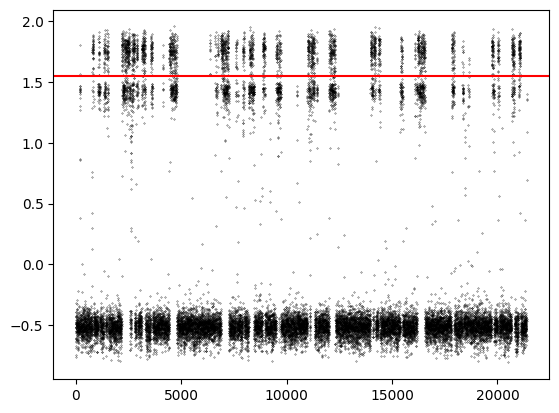

In [252]:
plt.plot(r_fun[:, 0].real, '.', color='k', markersize = 0.5)
plt.axhline(1.55, color='r')

Text(0.5, 1.0, 'They look like they are concentrated on the vertices of a simplex!!!')

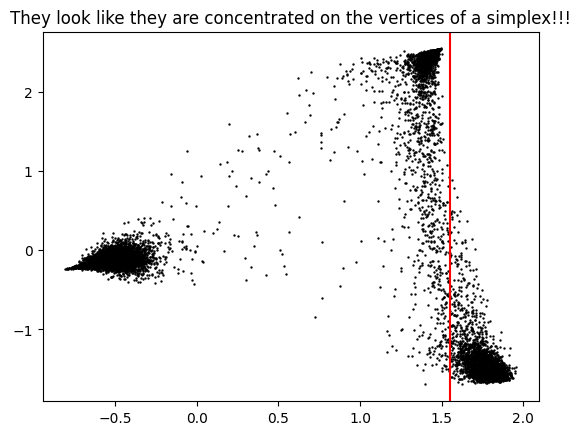

In [255]:
plt.scatter(r_fun[:, 0].real, r_fun[:, 1].real, color='k', s = 0.5)
plt.axvline(1.55, color='r')
plt.title("They look like they are concentrated on the vertices of a simplex!!!")